In [1]:
import pandas as pd
import numpy as np
import glob
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
from torch_geometric.data import Data
from torch_geometric.utils.convert import to_networkx
import networkx as nx # for visualizing graphs

import torch_geometric.nn as pyg_nn
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T
import torch.optim as optim
from copy import deepcopy
from torch_geometric.nn import GINConv
from torch.utils.data import DataLoader
from torch_geometric.datasets import TUDataset
from sklearn.metrics import *
from torch.nn import Sequential, Linear, ReLU
from deepsnap.dataset import GraphDataset
from deepsnap.batch import Batch

/clusterfs/ml4hep/mpettee/miniconda3/envs/pytorch_geo/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Simple example:

In [2]:
# Define two (bidirectional) edges: between nodes [0,1] and between nodes [1,2]:
edge_index = torch.tensor([[0, 1, 1, 2], 
                           [1, 0, 2, 1]], dtype=torch.long)

# Define node features 
x = torch.tensor([[-1], # node 0
                  [0],  # node 1
                  [1]], # node 2
                 dtype=torch.float)

# Put it all together
data = Data(x=x, edge_index=edge_index)

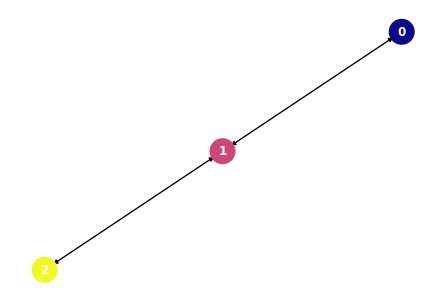

In [3]:
plt.figure() 
nx.draw(to_networkx(data), 
        cmap='plasma', 
        node_color = np.arange(data.num_nodes),
        with_labels=True,
        font_weight='bold',
        font_color='white',
        node_size=400, linewidths=6)

In [4]:
print("Graph nodes have {} node feature(s) each.".format(data.num_node_features))
print("Graph has {} nodes and {} edges.".format(data.num_nodes, data.num_edges))
print("Is the graph undirected?: {}".format(data.is_undirected()))

Graph nodes have 1 node feature(s) each.
Graph has 3 nodes and 4 edges.
Is the graph undirected?: True


# Load the ENZYMES dataset & visualize it

In [5]:
# load the dataset
from torch_geometric.datasets import TUDataset
enzymes = TUDataset(root='/tmp/ENZYMES', name='ENZYMES') 
print("Dataset has {} entries, with {} classes and {} node features.".format(len(enzymes), 
                                                                             enzymes.num_classes, 
                                                                             enzymes.num_node_features))
print("First entry has {:,} nodes and {:,} edges.".format(enzymes[0].num_nodes, enzymes[0].num_edges))
print("Is the graph undirected?: {}".format(enzymes[0].is_undirected()))

# now turn it into graphs
graphs = GraphDataset.pyg_to_graphs(enzymes) 
dataset = GraphDataset(graphs, task="graph", minimum_node_per_graph=0)
print("Dataset has {} classes".format(dataset.num_graph_labels))
print("Dataset has {} node features".format(dataset.num_node_features))

Dataset has 600 entries, with 6 classes and 3 node features.
First entry has 37 nodes and 168 edges.
Is the graph undirected?: True
Dataset has 6 classes
Dataset has 3 node features


In [6]:
enzymes[500].y # overall class of this protein

tensor([3])

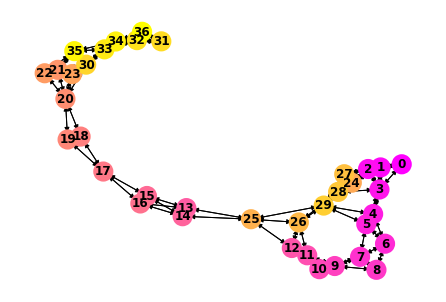

In [7]:
plt.figure() 
graph = enzymes[0]
nx.draw(to_networkx(graph), 
        cmap='spring', 
        with_labels=True,
        font_weight='bold',
        node_color = np.arange(graph.num_nodes),
        node_size=200, linewidths=6)

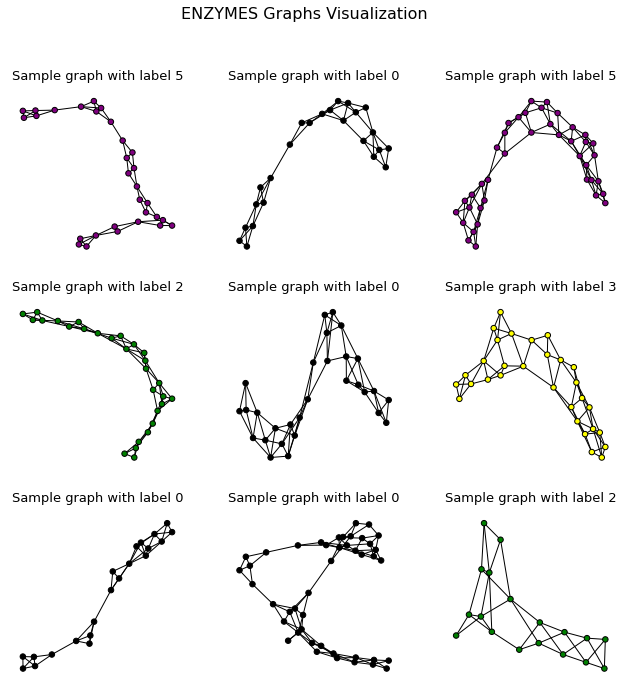

In [8]:
def visualize(dataset):
    color_mapping = {
        0 : 'black',
        1 : 'red',
        2 : 'green',
        3 : 'yellow',
        4 : 'blue',
        5 : 'purple',
    }
    num_graphs_i = 3
    num_graphs_j = 3
    fig, ax = plt.subplots(num_graphs_i, num_graphs_j, figsize=(11, 11))
    fig.suptitle("ENZYMES Graphs Visualization", fontsize=16)
    indices = np.random.choice(np.arange(0, len(dataset)), size=9, replace=False)
    indices = indices.reshape(3, 3)
    for i in range(num_graphs_i):
        for j in range(num_graphs_j):
            index = int(indices[i, j])
            G = dataset[index].G
            label = dataset[index].graph_label.item()
            pos = nx.spring_layout(G, seed=1)
            colors = [color_mapping[label]] * dataset[index].num_nodes
            nodes = nx.draw_networkx_nodes(G, pos=pos, cmap=plt.get_cmap('coolwarm'), \
                node_size=30, ax=ax[(i, j)], node_color=colors)
            nodes.set_edgecolor('black')
            nx.draw_networkx_edges(G, pos=pos, ax=ax[(i, j)])
            ax[(i, j)].set_title("Sample graph with label {}".format(label), fontsize=13)
            ax[(i, j)].set_axis_off()
    plt.show()
visualize(dataset)

Define a basic GNN for graph classification:

In [9]:
class GIN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, args):
        super(GIN, self).__init__()
        self.num_layers = args["num_layers"]

        self.pre_mp = nn.Linear(input_size, hidden_size)
        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()
        for l in range(self.num_layers):
            layer = Sequential(
                Linear(hidden_size, hidden_size), 
                nn.LeakyReLU(), 
                Linear(hidden_size, hidden_size)
            )
            self.convs.append(GINConv(layer))
            self.bns.append(nn.BatchNorm1d(hidden_size))
        self.post_mp = Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(), 
            nn.Linear(hidden_size, output_size),
        )

    def forward(self, data):
        x, edge_index, batch = data.node_feature, data.edge_index, data.batch
        x = self.pre_mp(x)
        for i in range(len(self.convs) - 1):
            x = self.convs[i](x, edge_index)
            x = self.bns[i](x)
        x = self.convs[-1](x, edge_index)
        x = pyg_nn.global_add_pool(x, batch)
        x = self.post_mp(x)
        x = F.log_softmax(x, dim=1)
        return x

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

Define train & test functions:

In [10]:
def train(train_loader, val_loader, test_loader, args, num_node_features, num_classes, device="cpu"):
    model = GIN(num_node_features, args["hidden_size"], num_classes, args).to(device)
    optimizer = optim.Adam(model.parameters(), lr=args['lr'], weight_decay=5e-4)
    best_model = None
    max_val = -1
    for epoch in range(args["epochs"]):
        total_loss = 0
        model.train()
        num_graphs = 0
        for batch in train_loader:
            batch.to(device)
            optimizer.zero_grad()
            pred = model(batch)
            label = batch.graph_label
            loss = model.loss(pred, label)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * batch.num_graphs
            num_graphs += batch.num_graphs
        total_loss /= num_graphs
        train_acc = test(train_loader, model, device)
        val_acc = test(val_loader, model, device)
        if val_acc > max_val:
            max_val = val_acc
            best_model = deepcopy(model)
        test_acc = test(test_loader, model, device)
        log = "Epoch {}: Train: {:.4f}, Validation: {:.4f}. Test: {:.4f}, Loss: {:.4f}"
        print(log.format(epoch + 1, train_acc, val_acc, test_acc, total_loss))
    return best_model

def test(loader, model, device='cuda'):
    model.eval()
    correct = 0
    num_graphs = 0
    for batch in loader:
        batch.to(device)
        with torch.no_grad():
            pred = model(batch).max(dim=1)[1]
            label = batch.graph_label
        correct += pred.eq(label).sum().item()
        num_graphs += batch.num_graphs
    return correct / num_graphs

Train!

In [11]:
args = {
    "device" : 'cpu', # 'cuda' if torch.cuda.is_available() else 'cpu',
    "hidden_size" : 50,
    "epochs" : 10,
    "lr" : 0.001,
    "num_layers": 3,
    "dataset" : "ENZYMES",
    "batch_size": 32,
}

pyg_dataset = TUDataset('./tmp/enzymes', args["dataset"])
graphs = GraphDataset.pyg_to_graphs(pyg_dataset)
dataset = GraphDataset(graphs, task="graph", minimum_node_per_graph=0)
dataset_train, dataset_val, dataset_test = \
    dataset.split(transductive=False, split_ratio = [0.8, 0.1, 0.1])
num_node_features = dataset.num_node_features
num_classes = dataset.num_graph_labels

train_loader = DataLoader(dataset_train, collate_fn=Batch.collate(),\
    batch_size=args["batch_size"], shuffle=True)
val_loader = DataLoader(dataset_val, collate_fn=Batch.collate(),\
    batch_size=args["batch_size"])
test_loader = DataLoader(dataset_test, collate_fn=Batch.collate(),\
    batch_size=args["batch_size"])

best_model = train(train_loader, val_loader, test_loader, args, num_node_features, num_classes, args["device"])
train_acc = test(train_loader, best_model, args["device"])
val_acc = test(val_loader, best_model, args["device"])
test_acc = test(test_loader, best_model, args["device"])
log = "Best model: Train: {:.4f}, Validation: {:.4f}. Test: {:.4f}"
print(log.format(train_acc, val_acc, test_acc))

Epoch 1: Train: 0.2062, Validation: 0.0500. Test: 0.2167, Loss: 3.3622
Epoch 2: Train: 0.2708, Validation: 0.2000. Test: 0.2500, Loss: 2.1445
Epoch 3: Train: 0.2979, Validation: 0.1500. Test: 0.3167, Loss: 1.9207
Epoch 4: Train: 0.3458, Validation: 0.2833. Test: 0.2833, Loss: 1.7130
Epoch 5: Train: 0.4021, Validation: 0.3667. Test: 0.3333, Loss: 1.6602
Epoch 6: Train: 0.3625, Validation: 0.2333. Test: 0.3333, Loss: 1.6136
Epoch 7: Train: 0.2979, Validation: 0.2167. Test: 0.2833, Loss: 1.6254
Epoch 8: Train: 0.3500, Validation: 0.2333. Test: 0.3500, Loss: 1.7009
Epoch 9: Train: 0.3937, Validation: 0.3167. Test: 0.4000, Loss: 1.6387
Epoch 10: Train: 0.3833, Validation: 0.3167. Test: 0.2833, Loss: 1.6331
Best model: Train: 0.4021, Validation: 0.3667. Test: 0.3333


In [12]:
def test(loader, model, device='cuda'): # with printouts
    model.eval()
    correct = 0
    num_graphs = 0
    batch_num = 0
    for batch in loader:
        print("====== BATCH {} ======".format(batch_num))
        batch.to(device)
        with torch.no_grad():
            pred = model(batch).max(dim=1)[1]
            print("Predicted labels:", pred)
            label = batch.graph_label
            print("True labels:", label)
        correct += pred.eq(label).sum().item()
        num_graphs += batch.num_graphs
        batch_num += 1
        print("Total graphs in batch:", batch.num_graphs)
        print("Number correctly predicted:", pred.eq(label).sum().item())
        print("Accuracy = {:.2f}%".format(100*pred.eq(label).sum().item()/batch.num_graphs))
    print("\nOut of all {} test graphs, {} predictions were correct.".format(num_graphs, correct))
    print("Total accuracy = {:.2f}%".format(100*correct/num_graphs))       
    return correct / num_graphs

In [13]:
test_acc = test(test_loader, best_model, args["device"])

====== BATCH 0 ======
Predicted labels: tensor([5, 4, 0, 4, 4, 2, 2, 1, 5, 1, 4, 0, 5, 1, 2, 1, 3, 2, 2, 2, 4, 4, 4, 4,
        1, 1, 2, 3, 5, 0, 4, 3])
True labels: tensor([5, 4, 2, 4, 0, 3, 3, 5, 5, 5, 3, 0, 5, 1, 3, 1, 5, 0, 3, 0, 5, 0, 4, 3,
        4, 0, 1, 4, 3, 4, 0, 1])
Total graphs in batch: 32
Number correctly predicted: 9
Accuracy = 28.12%
====== BATCH 1 ======
Predicted labels: tensor([5, 0, 4, 2, 1, 2, 3, 4, 1, 4, 3, 4, 4, 5, 1, 1, 5, 5, 2, 5, 1, 2, 4, 4,
        5, 5, 5, 5])
True labels: tensor([5, 3, 3, 1, 1, 2, 3, 3, 4, 4, 3, 0, 5, 5, 2, 1, 0, 0, 2, 3, 4, 2, 1, 5,
        5, 3, 2, 1])
Total graphs in batch: 28
Number correctly predicted: 11
Accuracy = 39.29%

Out of all 60 test graphs, 20 predictions were correct.
Total accuracy = 33.33%


# Okay, now try doing classification on pions as graphs! 

In [166]:
### Load data (multiple files)
pion_files = glob.glob("../data/onetrack_multicluster/pion_files/*.npy")
pi0_files = glob.glob("../data/onetrack_multicluster/pi0_files/*.npy") # obviously very few of these pass the STMC cuts

df_pion = pd.concat([pd.DataFrame(np.load(file, allow_pickle=True).item()) for file in tqdm(pion_files[:1])])
df_pi0 = pd.concat([pd.DataFrame(np.load(file, allow_pickle=True).item()) for file in tqdm(pi0_files)])

print("Pion dataframe has {:,} events.".format(df_pion.shape[0]))
print("Pi0 dataframe has {:,} events.".format(df_pi0.shape[0]))

100%|██████████| 10/10 [00:00<00:00, 23.31it/s]

Pion dataframe has 10,249 events.
Pi0 dataframe has 6,854 events.


In [167]:
def clean_dataframe(df, is_charged = True, max_n_cols=35): 
    ### Start the dataframe of inputs 
    # df2 = pd.DataFrame(pd.DataFrame(df.cluster_E.to_list())[0]) # just take the leading cluster E 
    df2 = pd.DataFrame(pd.DataFrame(df.cluster_E.to_list(), columns=["cluster_e_"+str(x) for x in np.arange(max_n_cols)]))
    
    ### Add track pT & truth particle E 
    track_pt = np.array(df.trackPt.explode())
    truth_particle_e = np.array(df.truthPartE.explode())
    track_eta = np.array(df.trackEta.explode())
    track_phi = np.array(df.trackPhi.explode())
    track_z0 = np.array(df.trackZ0.explode())

    df2["track_pt"] = track_pt
    df2["track_eta"] = track_eta
    df2["track_phi"] = track_phi
    df2["track_z0"] = track_z0
    if is_charged:
        df2["truth_particle_e"] = truth_particle_e
    else:
        df3 = pd.DataFrame(pd.DataFrame(df.truthPartE.to_list(), columns=["truth_particle_e_"+str(x) for x in np.arange(4)]))
        df2["truth_particle_e"] = df3.truth_particle_e_0
        
    ### Cluster_E > 0.5
    df2 = df2[df2.cluster_e_0 > 0.5]

    ### Lose outliers in track pT 
    df2 = df2[df2.track_pt < 5000]

    ### Cast as float
    df2 = df2.astype('float32')

    ### Add the log of all energy variables
    for var in df2.keys():
        if var in ["track_eta", "track_phi", "track_z0"]:
            continue
        else:
            df2['log10_'+var] = np.log10(df2[var])

    ### Drop infs/NaNs 
    df2.replace([np.inf, -np.inf], np.nan, inplace=True)
    df2 = df2.fillna(0)
    
    ### Reduce variables
    
    vars = [
    'log10_cluster_e_0', 
    'log10_track_pt',
    'track_eta', 
    'truth_particle_e'
             ]
    
    df2 = df2[vars]
    
    if is_charged:
        df2['label'] = 1
    else:
        df2['label'] = 0
        
    return df2

In [169]:
df_pion = clean_dataframe(df_pion, is_charged = True, max_n_cols=24)
df_pion

,log10_cluster_e_0,log10_track_pt,track_eta,truth_particle_e,label
0,2.733134,2.755852,-0.046391,718.672852,1
1,0.532984,0.829245,0.250689,6.982437,1
2,2.449312,2.230702,-1.919379,624.100647,1
3,1.436833,1.574001,-0.850665,50.317371,1
4,2.246385,1.939543,1.654420,233.040131,1
...,...,...,...,...,...
10244,2.920279,2.746367,1.361333,1110.349976,1
10245,2.814770,2.555299,-1.924242,1180.081543,1
10246,2.628423,2.075764,-2.137757,554.535095,1
10247,2.070517,1.728981,1.771104,156.071457,1


In [168]:
df_pi0 = clean_dataframe(df_pi0, is_charged = False, max_n_cols=13)
df_pi0

,log10_cluster_e_0,log10_track_pt,track_eta,truth_particle_e,label
0,1.686275,0.591320,-1.602209,57.029118,0
1,1.918844,0.032730,2.443249,113.261826,0
2,2.612776,-0.062958,2.409165,454.409119,0
3,1.201990,0.703816,1.768804,21.921974,0
4,1.264920,0.740012,-1.079699,22.411896,0
...,...,...,...,...,...
6849,2.035302,0.694576,0.261234,117.000282,0
6850,1.048462,0.041859,2.357090,30.642580,0
6851,0.423843,0.437515,-0.465798,3.708041,0
6852,2.819235,0.563282,-2.233699,672.980530,0


In [170]:
df = pd.concat([df_pion, df_pi0])
df

,log10_cluster_e_0,log10_track_pt,track_eta,truth_particle_e,label
0,2.733134,2.755852,-0.046391,718.672852,1
1,0.532984,0.829245,0.250689,6.982437,1
2,2.449312,2.230702,-1.919379,624.100647,1
3,1.436833,1.574001,-0.850665,50.317371,1
4,2.246385,1.939543,1.654420,233.040131,1
...,...,...,...,...,...
6849,2.035302,0.694576,0.261234,117.000282,0
6850,1.048462,0.041859,2.357090,30.642580,0
6851,0.423843,0.437515,-0.465798,3.708041,0
6852,2.819235,0.563282,-2.233699,672.980530,0


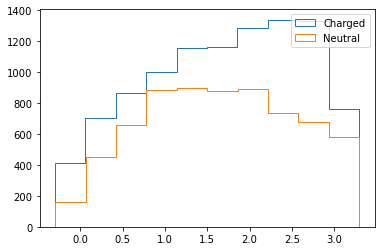

In [175]:
plt.hist(df[df.label == 1].log10_cluster_e_0, histtype="step", label="Charged");
plt.hist(df[df.label == 0].log10_cluster_e_0, histtype="step", label="Neutral");
plt.legend()